# TimeGrad: Blood Glucose Forecasting

**Model**: TimeGrad (Autoregressive Denoising Diffusion Model)  
**Library**: `pytorchts` (requires Python 3.11 venv)  
**Dataset**: Kaggle BrisT1D  
**Task**: Nocturnal blood glucose forecasting (6 hours)  
**Mode**: Train on training split, evaluate on validation split

**Requirements:** `source scripts/setup_model_env.sh timegrad`

TimeGrad is a probabilistic forecasting model that conditions a denoising diffusion process on a GRU-encoded history.
Unlike the foundation models (Sundial, TTM, Chronos), it must be trained from scratch — making it a strong
trainable diffusion baseline for comparison.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

from pts.model.time_grad import TimeGradEstimator
from pts import Trainer
from gluonts.dataset.common import ListDataset

from src.data.diabetes_datasets.data_loader import get_loader
from src.data.models import ColumnNames
from src.utils.time_series_helper import get_interval_minutes
from src.data.preprocessing.time_processing import iter_daily_context_forecast_splits

# --- Monkey-patch pytorchts for univariate (target_dim=1) compatibility -------
# TimeGrad's denoising network uses circular-padded Conv1d layers that fail when
# the sequence length (= target_dim) is 1, and a CondUpsampler whose intermediate
# dim floors to 0.  Patch both at import time so no installed files are modified.
import pts.model.time_grad.epsilon_theta as _et

_CondUp_init = _et.CondUpsampler.__init__


def _patched_cond_init(self, cond_length, target_dim):
    nn.Module.__init__(self)
    intermediate = max(target_dim // 2, 1)
    self.linear1 = nn.Linear(cond_length, intermediate)
    self.linear2 = nn.Linear(intermediate, target_dim)


_et.CondUpsampler.__init__ = _patched_cond_init

_EpsTheta_init = _et.EpsilonTheta.__init__


def _patched_eps_init(self, *args, **kwargs):
    _EpsTheta_init(self, *args, **kwargs)
    for m in self.modules():
        if isinstance(m, nn.Conv1d) and m.padding_mode == "circular":
            m.padding_mode = "zeros"


_et.EpsilonTheta.__init__ = _patched_eps_init
# ------------------------------------------------------------------------------

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")


def compute_metrics(predictions, targets):
    """Compute RMSE, MAE, MAPE for forecast evaluation."""
    y_pred = np.asarray(predictions).flatten()
    y_true = np.asarray(targets).flatten()
    return {
        "rmse": float(root_mean_squared_error(y_true, y_pred)),
        "mae": float(mean_absolute_error(y_true, y_pred)),
        "mape": float(
            np.mean(np.abs((y_pred - y_true) / np.where(y_true != 0, y_true, 1e-8)))
            * 100
        ),
    }

Device: cpu


In [ ]:
from pts.feature import lags_for_fourier_time_features_from_frequency
from pts.feature import fourier_time_features_from_frequency

# Configuration
INTERVAL_MINS = 5
NOCTURNAL_HOURS = 6
TARGET_COL = ColumnNames.BG.value

nocturnal_steps = int(NOCTURNAL_HOURS * 60 / INTERVAL_MINS)  # 72 steps
context_steps = int(18 * 60 / INTERVAL_MINS)  # 216 steps (6am-midnight daytime)

# GluonTS frequency string
freq = f"{INTERVAL_MINS}T"
TARGET_DIM = 1  # Univariate

# Compute input_size for TimeGrad's GRU using pts's own lag/time-feature functions.
# Formula: input_size = target_dim * n_lags + target_dim * embed_dim + n_time_feat_dims
# where embed_dim=1 (hardcoded in TimeGradTrainingNetwork).
# Each FourierDateFeature produces 2 dims (sin + cos), so n_time_feat_dims = 2 * n_features.

lags_seq = lags_for_fourier_time_features_from_frequency(freq)
time_feats = fourier_time_features_from_frequency(freq)
EMBED_DIM = 1  # Hardcoded in TimeGrad's network
time_feat_dims = 2 * len(time_feats)  # Each Fourier feature outputs (cos, sin)
input_size = TARGET_DIM * len(lags_seq) + TARGET_DIM * EMBED_DIM + time_feat_dims

print(f"Nocturnal steps    : {nocturnal_steps} ({NOCTURNAL_HOURS}h)")
print(f"Context steps      : {context_steps} (18h daytime)")
print(f"Frequency          : {freq}")
print(f"Lags ({len(lags_seq)})          : {lags_seq}")
print(f"Time feat dims     : {time_feat_dims} ({len(time_feats)} features × 2 sin/cos)")
print(f"Computed input_size: {input_size}")

Nocturnal steps    : 72 (6h)
Context steps      : 216 (18h daytime)
Frequency          : 5T
Lags (5)          : [1, 4, 12, 24, 48]
Time feat dims     : 6 (3 features × 2 sin/cos)
Computed input_size: 12


## Load Data

In [3]:
loader = get_loader(
    data_source_name="kaggle_brisT1D", dataset_type="train", use_cached=True
)
train_data = loader.train_data
val_data = loader.validation_data

print(f"Training patients  : {list(train_data.keys())}")
print(f"Validation patients: {list(val_data.keys())}")

2026-02-17T11:31:47 - ============================================================
2026-02-17T11:31:47 - Beginning data loading process with the following parmeters:
2026-02-17T11:31:47 - 	Dataset: kaggle_brisT1D - train
2026-02-17T11:31:47 - 	Columns: None
2026-02-17T11:31:47 - 	Generic patient start date: 2024-01-01 00:00:00
2026-02-17T11:31:47 - 	Number of validation days: 20
2026-02-17T11:31:47 - 	In parallel with up to 14 workers.

2026-02-17T11:31:47 - Loaded full processed data from cache for 9 patients
2026-02-17T11:31:47 - Loaded existing train/validation split from cache for 9 patients


Training patients  : ['p04', 'p05', 'p12', 'p03', 'p02', 'p10', 'p11', 'p06', 'p01']
Validation patients: ['p04', 'p05', 'p12', 'p03', 'p02', 'p10', 'p11', 'p06', 'p01']


## Build Training Dataset and Train

Build a GluonTS `ListDataset` — one entry per patient.
TimeGrad creates sliding windows over these time series internally during training.

In [4]:
train_list = []
skipped = []

for patient_id, df in train_data.items():
    if get_interval_minutes(df) != INTERVAL_MINS:
        skipped.append(patient_id)
        continue

    bg = df[TARGET_COL].values

    if np.isnan(bg).any():
        nan_frac = np.isnan(bg).mean()
        print(f"  {patient_id}: {nan_frac:.1%} NaN — forward-filling")
        bg = pd.Series(bg).ffill().bfill().values

    # TimeGrad expects 2D targets shaped (target_dim, timesteps) for multivariate API
    train_list.append({"target": bg.reshape(1, -1), "start": df.index[0]})

if skipped:
    print(f"Skipped (wrong interval): {skipped}")

train_dataset = ListDataset(train_list, freq=freq, one_dim_target=False)
print(f"\nTraining dataset: {len(train_list)} patient time series")
for i, (pid, entry) in enumerate(zip(train_data.keys(), train_list)):
    days = entry["target"].shape[1] * INTERVAL_MINS / 60 / 24
    print(f"  {pid}: {entry['target'].shape} ({days:.1f} days)")

  p04: 1.9% NaN — forward-filling
  p12: 4.4% NaN — forward-filling
  p03: 1.6% NaN — forward-filling
  p02: 1.6% NaN — forward-filling
  p10: 1.8% NaN — forward-filling
  p11: 4.4% NaN — forward-filling
Skipped (wrong interval): ['p05', 'p06', 'p01']

Training dataset: 6 patient time series
  p04: (1, 19018) (66.0 days)
  p05: (1, 20406) (70.9 days)
  p12: (1, 20458) (71.0 days)
  p03: (1, 20458) (71.0 days)
  p02: (1, 19882) (69.0 days)
  p10: (1, 19594) (68.0 days)


In [5]:
print("Initializing TimeGrad estimator...")

estimator = TimeGradEstimator(
    target_dim=TARGET_DIM,
    prediction_length=nocturnal_steps,
    context_length=context_steps,
    cell_type="GRU",
    input_size=input_size,
    freq=freq,
    loss_type="l2",
    scaling=True,  # Normalise internally (important for BG values)
    diff_steps=100,  # Diffusion steps (100 is standard from the paper)
    beta_end=0.1,
    beta_schedule="linear",
    trainer=Trainer(
        device=device,
        epochs=20,
        learning_rate=1e-3,
        num_batches_per_epoch=100,
        batch_size=32,
    ),
)

print("Training TimeGrad...")
predictor = estimator.train(train_dataset, num_workers=1)
print("\nTraining complete!")

Initializing TimeGrad estimator...
Training TimeGrad...


/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/torch/utils/data/dataloader.py:1118: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


  0%|          | 0/99 [00:01<?, ?it/s]

/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argum

  0%|          | 0/99 [00:01<?, ?it/s]

/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argum

  0%|          | 0/99 [00:01<?, ?it/s]

/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argum

  0%|          | 0/99 [00:01<?, ?it/s]

/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argum

  0%|          | 0/99 [00:01<?, ?it/s]

/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argum

  0%|          | 0/99 [00:01<?, ?it/s]

/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argum

  0%|          | 0/99 [00:01<?, ?it/s]

/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argum

  0%|          | 0/99 [00:01<?, ?it/s]

/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argum

  0%|          | 0/99 [00:01<?, ?it/s]

/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argum

  0%|          | 0/99 [00:01<?, ?it/s]

/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argum

  0%|          | 0/99 [00:01<?, ?it/s]

/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argum

  0%|          | 0/99 [00:01<?, ?it/s]

/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argum

  0%|          | 0/99 [00:01<?, ?it/s]

/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argum

  0%|          | 0/99 [00:01<?, ?it/s]

/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argum

  0%|          | 0/99 [00:01<?, ?it/s]

/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argum

  0%|          | 0/99 [00:01<?, ?it/s]

/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argum

  0%|          | 0/99 [00:01<?, ?it/s]

/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argum

  0%|          | 0/99 [00:02<?, ?it/s]

/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argum

  0%|          | 0/99 [00:01<?, ?it/s]

/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argum

  0%|          | 0/99 [00:01<?, ?it/s]

/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argum


Training complete!


## Evaluation

Evaluate on the validation set using the same day-split convention as Sundial:
- **Context**: Daytime data (6am–midnight, ~216 steps)
- **Target**: Nocturnal period (midnight–6am, 72 steps)

In [6]:
def timegrad_forecast(
    context: np.ndarray,
    start: pd.Timestamp,
    num_samples: int = 100,
):
    """
    Run TimeGrad forecast on a univariate context window.

    Returns: (median, q05, q95) for a 90% prediction interval.
    """
    # TimeGrad expects 2D targets: (target_dim, timesteps)
    context_2d = context.reshape(1, -1)

    test_entry = ListDataset(
        [{"target": context_2d, "start": start}],
        freq=freq,
        one_dim_target=False,
    )
    forecast_it = predictor.predict(test_entry, num_samples=num_samples)
    forecast = next(forecast_it)

    samples = forecast.samples  # (num_samples, prediction_length, target_dim)
    samples = samples.squeeze(-1)  # -> (num_samples, prediction_length)

    median = np.median(samples, axis=0)
    q05 = np.percentile(samples, 5, axis=0)
    q95 = np.percentile(samples, 95, axis=0)
    return median, q05, q95

In [7]:
day_results = []

print("Running evaluation on validation set...\n")

for patient_id, patient_df in val_data.items():
    if get_interval_minutes(patient_df) != INTERVAL_MINS:
        continue

    for daytime, nocturnal in iter_daily_context_forecast_splits(patient_df):
        context = daytime[TARGET_COL].values
        target = nocturnal[TARGET_COL].values[:nocturnal_steps]

        if np.isnan(context).any() or np.isnan(target).any():
            continue
        if len(context) < 10 or len(target) < nocturnal_steps:
            continue

        try:
            pred, q05, q95 = timegrad_forecast(context, daytime.index[0])
            day_results.append(
                {
                    "patient": patient_id,
                    "context": context,
                    "target": target,
                    "pred": pred.flatten(),
                    "q05": q05.flatten(),
                    "q95": q95.flatten(),
                    "daytime_df": daytime,
                }
            )
        except Exception as e:
            print(f"  Warning: forecast failed for {patient_id}: {e}")
            continue

print(f"Collected {len(day_results)} forecast days\n")

# Per-patient metrics
patient_metrics = []
for pid in sorted(set(r["patient"] for r in day_results)):
    patient_days = [r for r in day_results if r["patient"] == pid]
    preds = np.concatenate([r["pred"] for r in patient_days])
    targets = np.concatenate([r["target"] for r in patient_days])
    m = compute_metrics(preds, targets)
    patient_metrics.append(
        {"patient": pid, "rmse": m["rmse"], "mae": m["mae"], "days": len(patient_days)}
    )
    print(f"{pid}: RMSE={m['rmse']:.3f}, MAE={m['mae']:.3f} ({len(patient_days)} days)")

# Overall
all_preds = np.concatenate([r["pred"] for r in day_results])
all_targets = np.concatenate([r["target"] for r in day_results])
overall = compute_metrics(all_preds, all_targets)
print(
    f"\nOverall: RMSE={overall['rmse']:.3f}, MAE={overall['mae']:.3f}, MAPE={overall['mape']:.1f}%"
)

Running evaluation on validation set...



/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venvs/timegrad/lib/python3.11/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argum

Collected 98 forecast days

p02: RMSE=3.335, MAE=2.563 (16 days)
p03: RMSE=3.046, MAE=2.215 (18 days)
p04: RMSE=1.439, MAE=1.091 (16 days)
p10: RMSE=1.466, MAE=1.048 (15 days)
p11: RMSE=2.195, MAE=1.838 (17 days)
p12: RMSE=3.025, MAE=2.168 (16 days)

Overall: RMSE=2.553, MAE=1.837, MAPE=21.3%


In [8]:
pd.DataFrame(patient_metrics)

,patient,rmse,mae,days
0,p02,3.334985,2.563407,16
1,p03,3.045925,2.214557,18
2,p04,1.438922,1.090769,16
3,p10,1.465807,1.047808,15
4,p11,2.195230,1.838486,17
5,p12,3.025072,2.167810,16


## Visualization

Example forecasts with 90% prediction interval for one patient.

Patient p03: 18 valid days


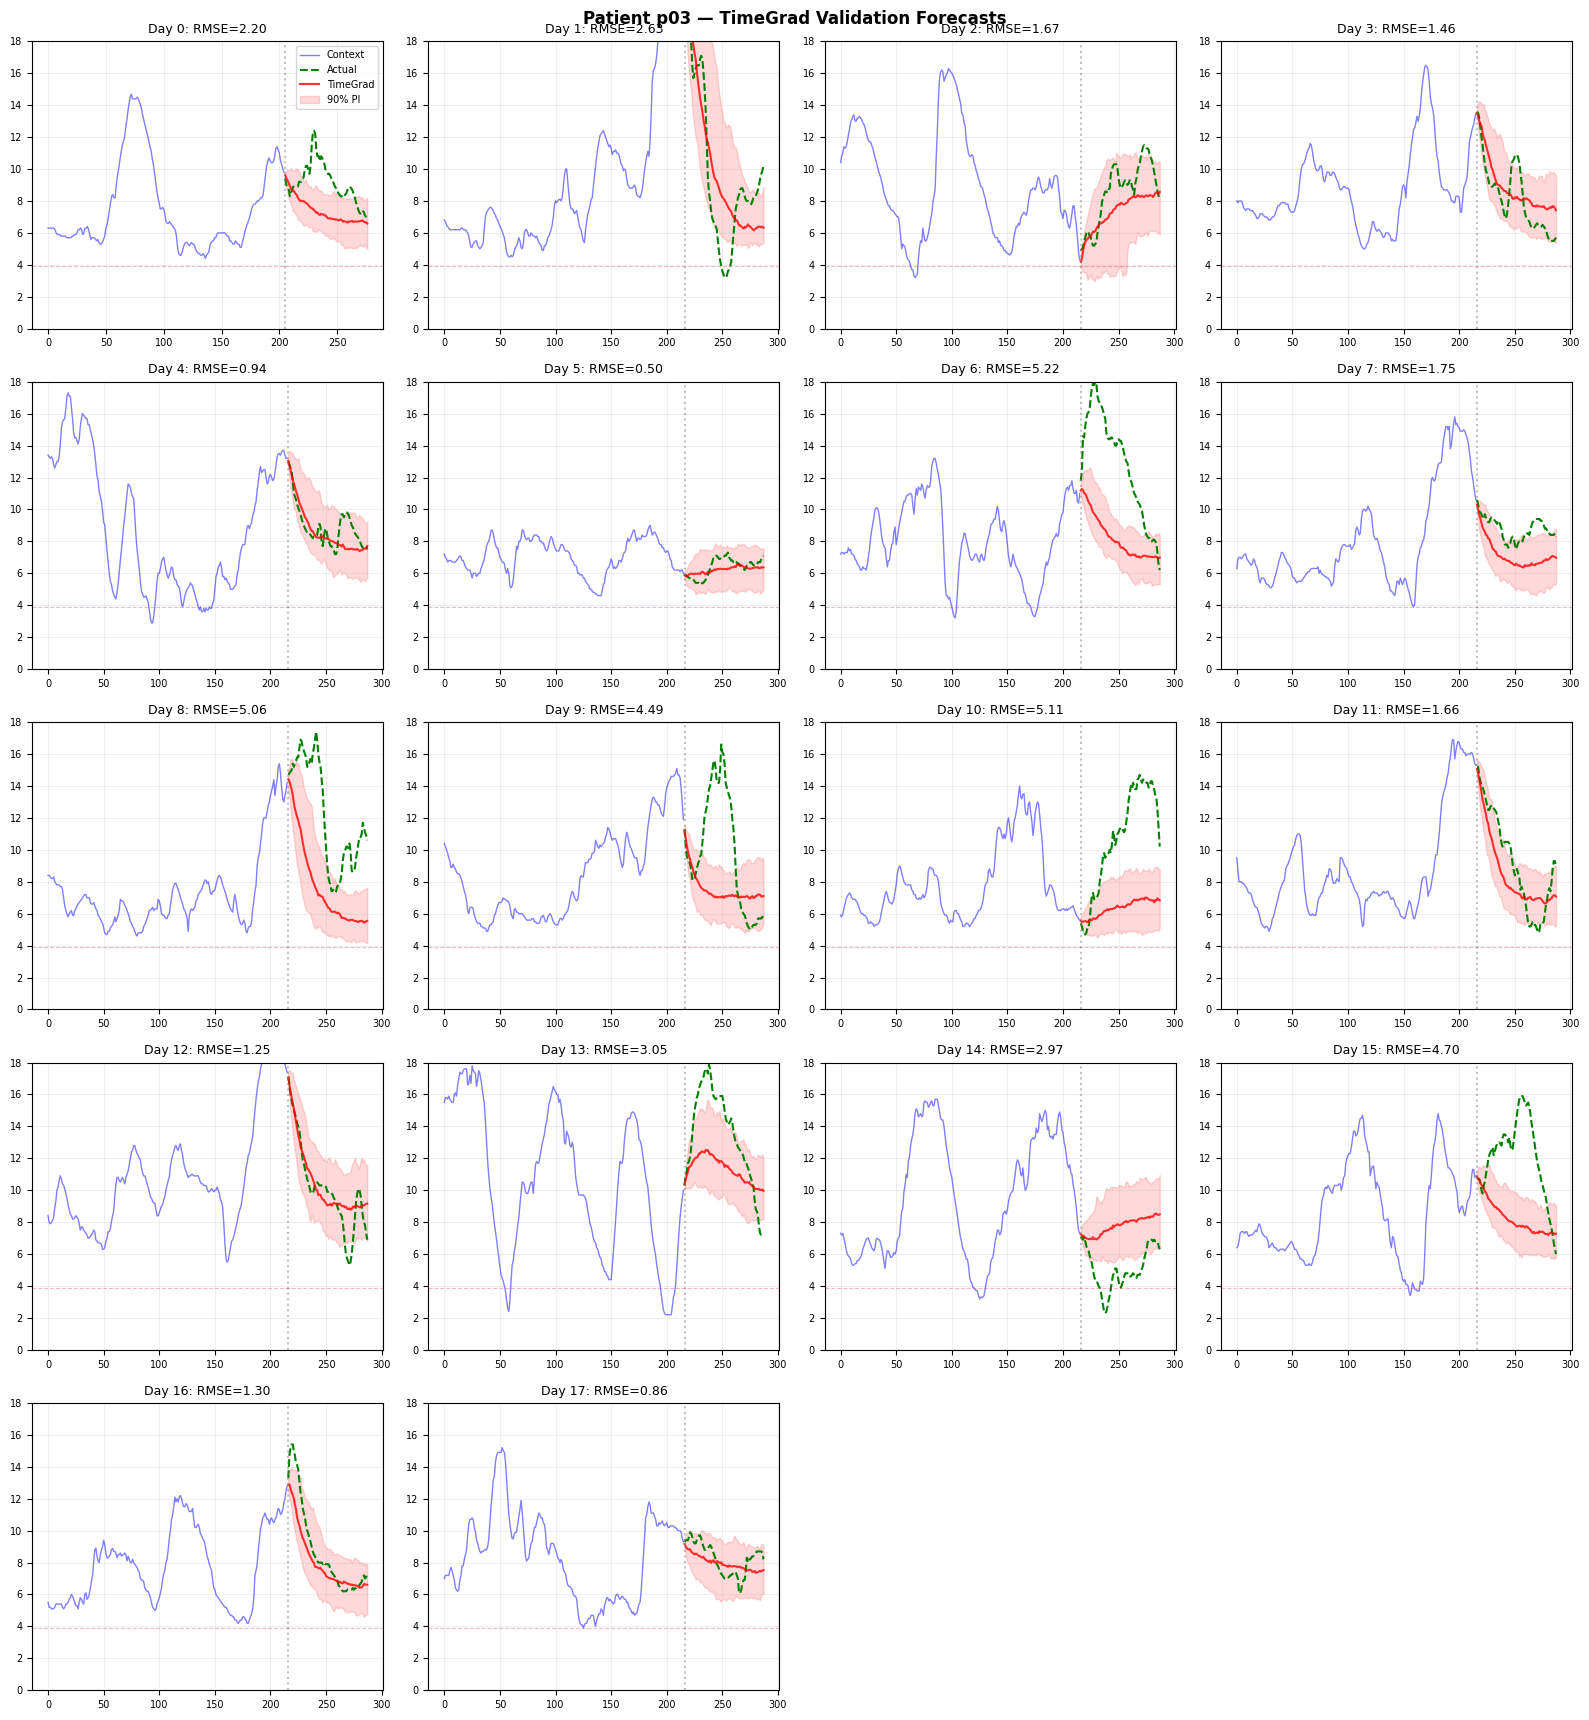

In [9]:
if not day_results:
    print("No results to visualize")
else:
    patient_counts = {
        pid: len([r for r in day_results if r["patient"] == pid])
        for pid in set(r["patient"] for r in day_results)
    }
    PATIENT = max(patient_counts, key=patient_counts.get)
    NCOLS = 4

    patient_days = [r for r in day_results if r["patient"] == PATIENT]
    num_days = len(patient_days)
    print(f"Patient {PATIENT}: {num_days} valid days")

    nrows = int(np.ceil(num_days / NCOLS))
    fig, axes = plt.subplots(nrows, NCOLS, figsize=(4 * NCOLS, 3.5 * nrows))
    axes = np.array(axes).flatten() if num_days > 1 else [axes]

    for i, day in enumerate(patient_days):
        ax = axes[i]
        context, target = day["context"], day["target"]
        pred, q05, q95 = day["pred"], day["q05"], day["q95"]

        t_ctx = np.arange(len(context))
        t_pred = np.arange(len(context), len(context) + len(target))

        ax.plot(t_ctx, context, "b-", alpha=0.5, lw=1, label="Context")
        ax.plot(t_pred, target, "g--", lw=1.5, label="Actual")
        ax.plot(t_pred, pred, "r-", lw=1.5, alpha=0.8, label="TimeGrad")
        ax.fill_between(t_pred, q05, q95, alpha=0.15, color="red", label="90% PI")

        ax.axvline(len(context), color="gray", ls=":", alpha=0.5)
        ax.axhline(3.9, color="crimson", ls="--", alpha=0.3, lw=0.8)

        rmse = compute_metrics(pred, target)["rmse"]
        ax.set_title(f"Day {i}: RMSE={rmse:.2f}", fontsize=9)
        ax.set_ylim(0, 18)
        ax.tick_params(labelsize=7)
        ax.grid(alpha=0.2)

    for j in range(num_days, len(axes)):
        axes[j].set_visible(False)

    axes[0].legend(fontsize=7, loc="upper right")
    fig.suptitle(
        f"Patient {PATIENT} — TimeGrad Validation Forecasts",
        fontsize=12,
        fontweight="bold",
    )
    plt.tight_layout()
    plt.show()